In [1]:
%load_ext autoreload
%autoreload 2

## data

In [2]:
import torch

from factorization.data.synthetic import (
    generate_transform,
    Factorizer,
    Sampler, 
    DirichletSampler,
    AggregatedSampler,
)

torch.random.manual_seed(0)

Deterministic transform

In [3]:
input_size = 10
output_size = 5
sampler = Sampler(input_size, output_size)
print(sampler.probas)

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]])


In [4]:
# ilustrating the generating function
inputs = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 1, 2, 1, 1, 3,])
targets = sampler.generate_targets(inputs)
print(targets)

tensor([4, 4, 3, 0, 3, 4, 2, 3, 2, 3, 4, 4, 3, 4, 4, 0])


Sparse transform

In [5]:
sparsity_index = 10
all_probas = [
    Sampler(input_size, output_size).probas for _ in range(sparsity_index)
]
sampler = AggregatedSampler(all_probas, epsilon=1e-3)
print(sampler.probas)

tensor([[4.9970e-01, 2.0000e-04, 1.0010e-01, 2.0000e-01, 2.0000e-01],
        [2.0000e-04, 2.0000e-01, 2.9990e-01, 3.9980e-01, 1.0010e-01],
        [2.9990e-01, 1.0010e-01, 2.9990e-01, 1.0010e-01, 2.0000e-01],
        [2.0000e-01, 2.9990e-01, 2.0000e-01, 2.9990e-01, 2.0000e-04],
        [2.0000e-04, 2.0000e-01, 2.0000e-01, 1.0010e-01, 4.9970e-01],
        [2.0000e-01, 2.0000e-01, 2.0000e-04, 2.0000e-01, 3.9980e-01],
        [1.0010e-01, 2.9990e-01, 1.0010e-01, 2.0000e-01, 2.9990e-01],
        [1.0010e-01, 1.0010e-01, 2.0000e-01, 1.0010e-01, 4.9970e-01],
        [3.9980e-01, 2.0000e-01, 2.0000e-01, 2.0000e-01, 2.0000e-04],
        [2.0000e-01, 1.0010e-01, 1.0010e-01, 2.0000e-01, 3.9980e-01]])


In [6]:
tmp = sum(all_probas)
tmp /= input_size
tmp *= (1 - 1e-3)
tmp += 1e-3 / output_size
assert torch.allclose(tmp, sampler.probas)

Random transform

In [7]:
alpha = 1
sampler = DirichletSampler(input_size, output_size, alpha)
print(sampler.probas)

tensor([[0.2649, 0.0625, 0.1046, 0.3650, 0.2031],
        [0.4859, 0.0046, 0.2810, 0.1338, 0.0947],
        [0.1982, 0.0459, 0.3593, 0.2103, 0.1864],
        [0.1445, 0.3282, 0.0426, 0.3749, 0.1098],
        [0.2558, 0.2781, 0.2610, 0.1473, 0.0579],
        [0.1019, 0.4135, 0.0127, 0.0185, 0.4534],
        [0.1891, 0.0014, 0.0172, 0.1071, 0.6852],
        [0.0548, 0.5081, 0.0892, 0.2946, 0.0533],
        [0.6038, 0.0844, 0.1579, 0.0968, 0.0570],
        [0.1845, 0.0112, 0.1306, 0.5585, 0.1152]])


## Factorization into factors (TODO I am here)

In [8]:
ps = torch.tensor([4, 6, 2, 5, 100, 3])
alpha = .5
qs = (alpha * ps).ceil().to(int)
print(qs)

max_x = ps.prod()
x = torch.linspace(0, max_x - 1, max_x - 1).to(int)

tensor([ 2,  3,  1,  3, 50,  2])


In [9]:
x_factorizer = Factorizer(ps)
y_factorizer = Factorizer(qs)

factors = x_factorizer(x)
print(1 - (factors != 0).to(float).mean(axis=0))
print(1 / ps)

tensor([0.2500, 0.1667, 0.5000, 0.2000, 0.0100, 0.3333], dtype=torch.float64)
tensor([0.2500, 0.1667, 0.5000, 0.2000, 0.0100, 0.3333])


In [10]:
transforms = [generate_transform(ps[i], qs[i]) for i in range(len(ps))]
transformed_factors = torch.zeros_like(factors)
for i in range(len(ps)):
    transformed_factors[:, i] = transforms[i][factors[:, i]]
y = y_factorizer.recomposition(transformed_factors)

In [27]:
x_tmp = x_factorizer.recomposition(factors)
y_transform = y_factorizer(y)
print((x_tmp == x).all(), (y_transform == transformed_factors).all())

tensor(True) tensor(True)


TODO: check if we have a better structure than just a modulo 5 operation

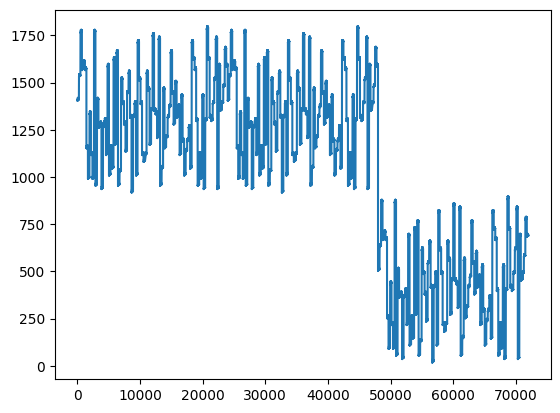

In [28]:
import matplotlib.pyplot as plt
plt.plot(x, y)

## model

We will have different architectures.
It would be nice to compute some form of cost for the different architecture in order to be able to do apple to apple comparison.

In some sense, we want to answer two questions:
- what kind of structure can be leveraged by neural networks?
- what kind of MLP architecture minimizes the cost?

In [11]:
from dataclasses import dataclass

import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """
    Multi-layer Perceptron.

    Parameters
    ----------
    config: configuration class with
        fan_in: int
            input dimension
        fan_out: int
            output dimension
        hidden_dim: int, or list of int
            hidden dimension(s) of the MLP
        activation: str
            activation function. Options are "relu", "gelu", or any name for F.name.
        residual: bool
            whether to use residual connection
        dropout: float
            dropout rate
    """

    def __init__(self, config):
        super().__init__()

        if isinstance(config.hidden_dim, int):
            hidden_dim = [config.hidden_dim]
        else:
            hidden_dim = config.hidden_dim

        # residual connection
        self.residual = config.residual

        # linear and normalization layers
        fan_in = config.fan_in
        norms = []
        layers = []
        for fan_out in hidden_dim:
            if self.residual:
                assert fan_in == fan_out, "fan_in and fan_out must be the same for residual connection"
            norms.append(nn.RMSNorm(fan_in, elementwise_affine=False))
            layers.append(nn.Linear(fan_in, fan_out, bias=True))
            fan_in = fan_out
        self.norms = nn.Sequential(*norms)
        self.layers = nn.Sequential(*layers)

        self.norm = nn.RMSNorm(fan_in, elementwise_affine=False)
        self.output = nn.Linear(fan_in, config.fan_out, bias=True)

        # activation function
        activation = config.activation.lower()
        self.activation = getattr(F, activation)


        # dropout regularization
        self.dropout = config.dropout

    def forward(self, x):
        for layer, norm in zip(self.layers, self.norms):
            out = norm(x)
            out = layer(out)
            out = self.activation(out)
            if self.residual:
                out = out + x
            x = F.dropout(out, p=self.dropout, training=self.training)
        x = self.norm(x)
        out = self.output(x)
        return out


@dataclass
class Config:
    vocab_size: int = None
    emb_dim: int = None
    nb_layers: int = None
    activation: str = "relu"
    dropout: float = 0.0

    def __post_init__(self):
        self.fan_in = self.emb_dim
        self.fan_out = self.vocab_size
        self.hidden_dim: list = [self.emb_dim, ] * self.nb_layers
        self.residual: bool = True



class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb = nn.Embedding(config.vocab_size, config.emb_dim)
        self.model = MLP(config)

    def forward(self, inputs):
        emb = self.emb(inputs)
        out = self.model(emb)
        return out

In [13]:
vocab_size = 10
config = Config(
    vocab_size=vocab_size,
    emb_dim=32,
    nb_layers=2,
    activation="relu",
    dropout=0.0,
)

model = Model(config)

AttributeError: module 'torch.nn' has no attribute 'RMSNorm'

In [ ]:
torch.randint(0, 10, (1000, )).max()

tensor(9)

## training

In [ ]:
n_epochs = 100
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

losses = torch.empty(n_epochs)

inputs = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
outputs = torch.stack([generator_given_x[inp].sample() for inp in inputs])
targets = torch.stack([probas[inp] for inp in inputs])

min_loss = F.cross_entropy(torch.log(targets), targets).item()

model.to(device)
inputs = inputs.to(device)
targets = targets.to(device)

for epoch in range(n_epochs):
    # training

    logits = model(inputs)
    loss = F.cross_entropy(logits, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[epoch] = loss.item() - min_loss

[]

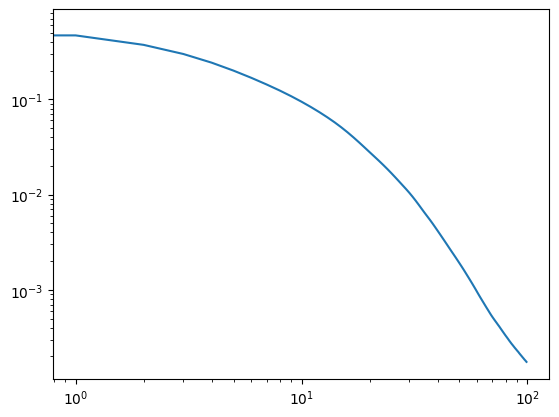

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.loglog()